In [66]:
from collections import defaultdict

import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE
import xgboost as xgb

In [67]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '2y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'AAPL'      # Symbol of the desired stock

# one day 16 rows of data

In [68]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523
2019-05-13 12:30:00-04:00,46.645000,46.709999,46.270000,46.342499,46.342499,5015671
...,...,...,...,...,...,...
2021-05-11 14:30:00-04:00,126.220001,126.220001,125.540001,125.964996,125.964996,9989427
2021-05-11 15:30:00-04:00,125.973503,126.110001,125.279999,125.849998,125.849998,9604428
2021-05-11 16:00:00-04:00,125.850000,126.100000,122.770000,125.690000,125.690000,5589756


In [69]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low','close','volume']

In [70]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [71]:
# for name in important_columns:
#     for i in range(1, 11):
#         calculate_diffs(i, name)
#
# data.head(10)

In [72]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

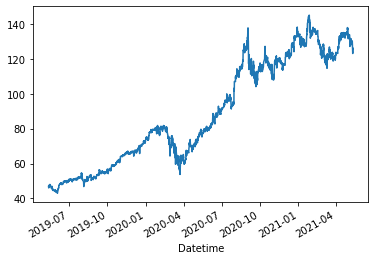

In [73]:
data['close'].plot()

In [74]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0,NaN
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487,-0.001844
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368,0.000191
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523,-0.003285
2019-05-13 12:30:00-04:00,46.645000,46.709999,46.270000,46.342499,46.342499,5015671,-0.006512


In [75]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,8207.000000,8.207000e+03,8207.000000,8207.000000,8207.000000,8.207000e+03,8206.000000
mean,89.233341,7.874161e+06,88.795820,89.234976,89.234976,3.498162e+06,0.000138
std,30.158631,7.133317e+08,29.950542,30.152787,30.152787,6.683672e+06,0.006025
min,42.970001,4.332500e+01,42.567501,42.972500,42.972500,0.000000e+00,-0.085960
25%,62.252500,6.273504e+01,61.843751,62.225000,62.225000,0.000000e+00,-0.001749
50%,80.305000,8.053000e+01,80.055000,80.312500,80.312500,0.000000e+00,0.000097
75%,119.830002,1.203300e+02,119.019998,119.840000,119.840000,4.252566e+06,0.002047
max,144.900000,6.462250e+10,144.590000,144.910000,144.910000,9.845401e+07,0.078661


In [76]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [77]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0,NaN
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487,-0.001844
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368,0.000191
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523,-0.003285
2019-05-13 12:30:00-04:00,46.645000,46.709999,46.270000,46.342499,46.342499,5015671,-0.006512
...,...,...,...,...,...,...,...
2021-05-11 14:30:00-04:00,126.220001,126.220001,125.540001,125.964996,125.964996,9989427,-0.002021
2021-05-11 15:30:00-04:00,125.973503,126.110001,125.279999,125.849998,125.849998,9604428,-0.000913
2021-05-11 16:00:00-04:00,125.850000,126.100000,122.770000,125.690000,125.690000,5589756,-0.001271


In [78]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [79]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [80]:
data = _get_indicator_data(data)
data['close_shift'] = data.shift(-WINDOW)['close']
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0,NaN,-0.000000e+00,0,0.000000,...,0.000000,46.877500,0.000000,0.000000,0.000000,0.000000,-47.467347,0.000000,0.000000,46.387500
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487,-0.001844,-4.355401e+06,-19332487,-0.225289,...,0.000000,46.839569,0.000000,107.692308,107.692308,0.000000,-0.184417,-0.184587,-0.184417,46.246376
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368,0.000191,-6.260972e+06,-12982119,-0.243780,...,0.000000,46.822096,0.000000,94.484442,105.050735,-10.566293,0.019126,0.019124,-0.165326,46.237500
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523,-0.003285,-7.922405e+06,-17518642,-0.262163,...,0.000000,46.743707,0.000000,82.764981,100.593584,-17.828603,-0.328520,-0.329061,-0.493303,46.057500
2019-05-13 12:30:00-04:00,46.645000,46.709999,46.270000,46.342499,46.342499,5015671,-0.006512,-1.128522e+07,-22534313,-0.320284,...,0.000000,46.563061,0.000000,73.817533,95.238374,-21.420840,-0.651184,-0.653313,-1.141275,46.640000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 14:30:00-04:00,126.220001,126.220001,125.540001,125.964996,125.964996,9989427,-0.002021,1.189229e+09,207288588,0.045593,...,-1.843727,124.058806,-0.281035,29.113071,19.312710,9.800361,-0.202110,-0.202315,168.710994,NaN
2021-05-11 15:30:00-04:00,125.973503,126.110001,125.279999,125.849998,125.849998,9604428,-0.000913,1.192816e+09,197684160,0.081626,...,-1.413227,124.155581,1.003209,25.895957,20.629360,5.266598,-0.091294,-0.091335,168.465679,NaN
2021-05-11 16:00:00-04:00,125.850000,126.100000,122.770000,125.690000,125.690000,5589756,-0.001271,1.197029e+09,192094404,0.167306,...,-1.399845,124.327777,0.785823,19.912664,20.486020,-0.573356,-0.127134,-0.127215,168.124367,NaN


In [81]:
def create_class(df):
    higher_threshold = 1.5
    lowest_threshold = -1.5
    last_values_higher = []
    last_values_lower = []
    df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
    while True:
        class_counts = df['class_column'].value_counts()
        if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
            break

        if len(last_values_higher) == 3:
            last_values_higher.pop(0)
        if len(last_values_lower) == 3:
            last_values_lower.pop(0)

        last_values_higher.append(higher_threshold)
        last_values_lower.append(lowest_threshold)
        if class_counts[0] > class_counts[1]:
            higher_threshold -= 0.01
        if class_counts[0] > class_counts[-1]:
            lowest_threshold += 0.01
        if class_counts[0] < class_counts[1]:
            higher_threshold += 0.01
        if class_counts[0] < class_counts[-1]:
            lowest_threshold -= 0.01

        if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
            break
        df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)),
                                          axis=1)
    print(df['class_column'].value_counts())
    return df


data = create_class(data)

data


 1    2796
-1    2712
 0    2699
Name: class_column, dtype: int64


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0,NaN,-0.000000e+00,0,0.000000,...,46.877500,0.000000,0.000000,0.000000,0.000000,-47.467347,0.000000,0.000000,46.387500,-1
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487,-0.001844,-4.355401e+06,-19332487,-0.225289,...,46.839569,0.000000,107.692308,107.692308,0.000000,-0.184417,-0.184587,-0.184417,46.246376,-1
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368,0.000191,-6.260972e+06,-12982119,-0.243780,...,46.822096,0.000000,94.484442,105.050735,-10.566293,0.019126,0.019124,-0.165326,46.237500,-1
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523,-0.003285,-7.922405e+06,-17518642,-0.262163,...,46.743707,0.000000,82.764981,100.593584,-17.828603,-0.328520,-0.329061,-0.493303,46.057500,-1
2019-05-13 12:30:00-04:00,46.645000,46.709999,46.270000,46.342499,46.342499,5015671,-0.006512,-1.128522e+07,-22534313,-0.320284,...,46.563061,0.000000,73.817533,95.238374,-21.420840,-0.651184,-0.653313,-1.141275,46.640000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 14:30:00-04:00,126.220001,126.220001,125.540001,125.964996,125.964996,9989427,-0.002021,1.189229e+09,207288588,0.045593,...,124.058806,-0.281035,29.113071,19.312710,9.800361,-0.202110,-0.202315,168.710994,NaN,0
2021-05-11 15:30:00-04:00,125.973503,126.110001,125.279999,125.849998,125.849998,9604428,-0.000913,1.192816e+09,197684160,0.081626,...,124.155581,1.003209,25.895957,20.629360,5.266598,-0.091294,-0.091335,168.465679,NaN,0
2021-05-11 16:00:00-04:00,125.850000,126.100000,122.770000,125.690000,125.690000,5589756,-0.001271,1.197029e+09,192094404,0.167306,...,124.327777,0.785823,19.912664,20.486020,-0.573356,-0.127134,-0.127215,168.124367,NaN,0


In [82]:
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

C:\Users\exomat\Desktop\repo\magisterka_analiza\data\results\train_test\AAPL_2y_8_diff_12_05_2021 00_52_20_full.csv


In [83]:

# Class divide
data['class_column'].value_counts()

 1    2796
-1    2712
 0    2699
Name: class_column, dtype: int64

In [84]:
# del (data['close'])
# del (data['close_shift'])
data = data.dropna()

In [85]:
data['class_column'].value_counts()


 1    2796
-1    2711
 0    2691
Name: class_column, dtype: int64

In [86]:
def split_dataframe(df, chunk_size = 17):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [87]:
splited_dataframe = split_dataframe(data, 17)
len(splited_dataframe)

483

In [88]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column', 'close_shift']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [89]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['XGBClassifier'] = xgb.XGBClassifier(nthread =-1,max_depth=10,n_estimators=1000, eta =0.2)
classifiers['XGBRFClassifier'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1,max_depth=12,n_estimators =100,eta=0.4)
classifiers_boosted = dict()
classifiers_boosted['GradientBoostingClassifier 1S'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers_boosted['GradientBoostingClassifier 2S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers_boosted['GradientBoostingClassifier 3S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers_boosted['GradientBoostingClassifier 4S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.8)



In [90]:
start_data = splited_dataframe[:100]
next_data = splited_dataframe[100:]
score = defaultdict(list)
score_train = defaultdict(list)
step_headers = []
i = 0
print("start")
for idx, day in enumerate(next_data):
    start_data.append(day)
    data_set = pd.concat(start_data)
    data_set = create_class(data_set)
    print(data_set['class_column'].value_counts())
    y = data_set['class_column']
    features = [x for x in data_set.columns if x not in ['class_column']]
    x = data_set[features]
    x_train= x.iloc[:-17]
    y_train= y.iloc[:-17]
    x_test =x.iloc[-17:]
    y_test=y.iloc[-17:]

    print(len(data_set))

    step_headers.append(f'<{i}>')
    i= i +1
    predictions_train= dict()
    predictions= dict()

    for k,v in classifiers.items():
        print("Calculate: ", k)
        train_model(v,x_train,y_train)
        predictions_train[k] = v.predict(x_train)
        score_train[k].append(accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test)
        score[k].append(accuracy_score(y_test.values, predictions[k]))

    rfe = RFE(classifiers['RandomForestClassifier 5'],10)
    fited = rfe.fit(x_train, y_train)
    names = x.columns
    columns=[]
    for i in range(len(fited.support_)):
        if fited.support_[i]:
            columns.append(names[i])

    print("Columns with predictive power:", columns )
    columns = columns + ['high', 'low', 'volume', 'open']
    x_test_cropped = x_test[columns]
    x_train_cropped = x_train[columns]
    for k,v in classifiers_boosted.items():
        print("Calculate: ", k)
        train_model(v,x_train_cropped,y_train)
        predictions_train[k] = v.predict(x_train_cropped)
        score_train[k].append( accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test_cropped)
        score[k].append(accuracy_score(y_test.values, predictions[k]))




start
 1    573
-1    572
 0    572
Name: class_column, dtype: int64
 1    573
-1    572
 0    572
Name: class_column, dtype: int64
1717
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  DecisionTreeClassifier 3
Calculate:  RandomForestClassifier 4
Calculate:  RandomForestClassifier 5
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  XGBClassifier
[00:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Calculate:  XGBRFClassifier
[00:54:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_adi', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_macd_signal', 'trend_ema_slow', 'trend_kst_sig', 'trend_visual_ichimoku_a', 'trend_stc', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
Calculate:  GradientBoostingClassifier 2S
Calculate:  GradientBoostingClassifier 3S
Calculate:  GradientBoostingClassifier 4S
 1    598
-1    574
 0    562
Name: class_column, dtype: int64
 1    598
-1    574
 0    562
Name: class_column, dtype: int64
1734
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  DecisionTreeClassifier 3
Calculate:  RandomForestClassifier 4
Calculate:  RandomForestClassifier 5
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  XGBClassifier
[00:56:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softpro

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Calculate:  XGBRFClassifier
[00:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_adi', 'volume_cmf', 'volatility_bbw', 'volatility_dcw', 'trend_macd_signal', 'trend_ema_slow', 'trend_kst_sig', 'trend_visual_ichimoku_a', 'trend_stc', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
Calculate:  GradientBoostingClassifier 2S
Calculate:  GradientBoostingClassifier 3S
Calculate:  GradientBoostingClassifier 4S
 1    593
 0    584
-1    574
Name: class_column, dtype: int64
 1    593
 0    584
-1    574
Name: class_column, dtype: int64
1751
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  DecisionTreeClassifier 3
Calculate:  RandomForestClassifier 4
Calculate:  RandomForestClassifier 5
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  XGBClassifier
[00:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' w

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Calculate:  XGBRFClassifier
[00:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_adi', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_trix', 'trend_kst', 'trend_kst_sig', 'trend_visual_ichimoku_a', 'trend_stc', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
Calculate:  GradientBoostingClassifier 2S
Calculate:  GradientBoostingClassifier 3S
Calculate:  GradientBoostingClassifier 4S
-1    603
 1    596
 0    569
Name: class_column, dtype: int64
-1    603
 1    596
 0    569
Name: class_column, dtype: int64
1768
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  DecisionTreeClassifier 3
Calculate:  RandomForestClassifier 4
Calculate:  RandomForestClassifier 5
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  XGBClassifier
[01:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was chang

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Calculate:  XGBRFClassifier
[01:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


KeyboardInterrupt: 

In [ ]:
headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type",] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['Accuracy'].tolist(), index= score_df.index, columns=step_headers)
score_df = score_df.drop('Accuracy', 1)
f_out = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['mean'] = f_out.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out,headers2 , tablefmt="psql"))

filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

f_out.to_csv(filename_to_export, index=False)